# COSC6336 Homework 1

## Introduction
In this project, you will work on the text classification task of automatically identifying informative/uninformative tweets about COVID-19.

First, download the data by run the command in the cell below. The dataset is downloaded to the Colab file storage. If you prefer to work on your machines, you can download the code and dataset to your machine.

In [ ]:
!gdown 1hCdscwOk5O9j7KqMCYk2yIYkeyKbXRDQ

Downloading...
From: https://drive.google.com/uc?id=1hCdscwOk5O9j7KqMCYk2yIYkeyKbXRDQ
To: /content/infomative_tweet.tsv
100% 1.30M/1.30M [00:00<00:00, 173MB/s]


In [ ]:
import pandas as pd
import numpy as np

Read the data using `Pandas`:

In [ ]:
df = pd.read_csv("infomative_tweet.tsv", sep='\t')

Preview the dataframe:

In [ ]:
df

,Id,Text,Label,Class
0,1244051803903328258,This ignores: 1. 5000 Italian Rugby Fans allow...,UNINFORMATIVE,0
1,1242016817863892992,"1/2 Some good news and some bad news , new rec...",INFORMATIVE,1
2,1242155318475468801,Ace reporting by @USER Title IX sexual-assault...,UNINFORMATIVE,0
3,1245746251582377984,"Canada's Chief Public Health Officer, Dr. Ther...",INFORMATIVE,1
4,1239187176954478593,Very sad to hear a member of staff at Fortisme...,INFORMATIVE,1
...,...,...,...,...
4995,1244481231779233792,#BreakingNews: A 45 year old healthcare worker...,INFORMATIVE,1
4996,1245688974506688518,"ScHARRSheffield: RT ShefUniNews: ""The main rea...",UNINFORMATIVE,0
4997,1241077936062705664,Researchers developed imaging technology calle...,UNINFORMATIVE,0
4998,1242855817449267205,After spending 4 hours pouring over Britain's ...,UNINFORMATIVE,0


## Data fact study

Now, it's your turn. In the following code blocks:


1.   Investigate the text length (word count) distributions of the dataset. You should create a histogram or a box plot.

2.   Create a barplot for label distribution.

You can use `matplotlib` or `seaborn` or any other tools you like.



Text length (total word count) distribution: 

Hint: tools like `NLTK` might be helpful.

In [ ]:
### your code for text length distributions plot
import matplotlib.pyplot as plt 

tweetsByWordCount = {}

for tweet in df['Text']:
  words = tweet.split(' ')

  ### Counting the number of words in a tweet
  numberOfWords = len(words)
  tweetsByWordCount[numberOfWords] = tweetsByWordCount.get(numberOfWords, 0) + 1

# Adding some logs here to explain the rational behind the loop - Counting the number of words in a tweet
sampleIndex = 1
print ("Example of a tweet: ", df['Text'][sampleIndex])
print ("We extract words from that tweet: ", df['Text'][sampleIndex].split(' '))
print ("And count the number of words from that tweet to generate the graph, for example: ", 
       len(df['Text'][sampleIndex].split(' ')), "\n\n")

textWordCount, wordOccurance = zip(*tweetsByWordCount.items())  # wordOccurance could be called "numTweetsThatLong" or sth if using the alternative counting approach...

f = plt.figure()
f.set_figheight(10)
f.set_figwidth(40)

key_max = max(tweetsByWordCount.values(), key=(lambda k: tweetsByWordCount.get(k, 0)))
key_min = min(tweetsByWordCount.values(), key=(lambda k: tweetsByWordCount.get(k, 0)))

plt.bar(textWordCount, wordOccurance)
plt.xlim([key_max, 100])
plt.xlabel('Text Word Count')
plt.ylabel('Number of Tweets')

NameError: ignored

Label distribution:

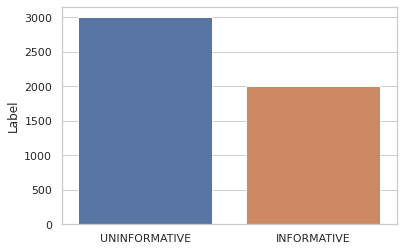

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=df.Label.value_counts().index, y=df.Label.value_counts(), data=df)

## Feature extraction

Now we can prepare feature extraction on text. 


1.   Convert the text data into bag-of-word vectors.
2.   Convert the bag-of-word vectors into TF-IDF representations.

This doc could be helpful: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#working-with-text-data



In [ ]:
import math
### Build a vocabulary with an integer index mapped to each unique word
vocab = {}
for tweet in df['Text']:
  for word in tweet.split():
    if word not in vocab:
      vocab[word] = len(vocab)

### Convert labels to numeric indexes
labels = {'UNINFORMATIVE': 0, 'INFORMATIVE': 1}
labelsByTweet = pd.Series([labels[label] for label in df['Label']])

### Convert to BoW vectors
BoWsByTweet = []

for tweet in df['Text']:
  currentTweetBoW = {}
  for word in tweet.split():
    currentTweetBoW[vocab[word]] = currentTweetBoW.get(vocab[word], 0) + 1
  BoWsByTweet += [currentTweetBoW]

### Convert to TF-IDF representations
numTweets = len(BoWsByTweet)

# Pre-count number of tweets that contain a word (DF) for each word in any tweet (for performance)
tweetsWithEachWord = {}

for BoW in BoWsByTweet:
  for vocabIdx in BoW.keys():
    tweetsWithEachWord[vocabIdx] = tweetsWithEachWord.get(vocabIdx, 0) + 1

# Calculate IDF for each word (log numTweets / DF)
idf = {vocabIdx: math.log2(numTweets / tweetsWithEachWord[vocabIdx])        # Not sure what base of logarithm we need...
        for vocabIdx in tweetsWithEachWord.keys()}

# Calculate TF for each word in each BoW
tfByTweet = []
for BoW in BoWsByTweet:
  numWordsInTweet = sum(BoW.values())
  currentTf = {vocabIdx: BoW[vocabIdx] / numWordsInTweet 
                for vocabIdx in BoW.keys()}
  tfByTweet += [currentTf]

# Multiply the TFs in each BoW by the IDFs for the respective words to get TF-IDFs
tfidfByTweet = [{vocabIdx: tf[vocabIdx] * idf[vocabIdx]
                    for vocabIdx in tf.keys()}
                  for tf in tfByTweet]
        
# Convert dictionary to sparse matrix
from scipy.sparse import *
mat_tfidf = dok_matrix((len(tfidfByTweet), len(vocab)))
for i in range(len(tfidfByTweet)):
  for vocabIdx in tfidfByTweet[i].keys():
    mat_tfidf[i, vocabIdx] = tfidfByTweet[i][vocabIdx]

### Done! (?)

## Data split

Next, we will split the extracted feature vectors into train/dev/test sets.


*   Set the proportion of train/dev/test = 7:1:2
*   Different sets should keep the same proportions of informative/uninformative instances as observed in the original dataset.




You can implement the split yourself or use this function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Hint: check out the parameter `stratify` in `train_test_split`.

In [ ]:
from sklearn.model_selection import train_test_split
y = labelsByTweet #Target Variable
X = mat_tfidf #Independent Variable
X_train, X_rem, y_train, y_rem = train_test_split(X, y, stratify=y, train_size=3500)  
X_test, X_dev, y_test, y_dev = train_test_split(X_rem, y_rem, stratify=y_rem, test_size=500) 

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_dev.shape), print(y_dev.shape)
print(X_test.shape), print(y_test.shape)

(3500, 32817)
(3500,)
(500, 32817)
(500,)
(1000, 32817)
(1000,)


(None, None)

You should split the data as following example parts.
*   X_train
*   X_dev 
*   X_test
*   y_train
*   y_dev
*   y_test

Remember to check proportion.

## Train and evaluate using sklearn

Use a Logistic Regression model from Scikit-learn to do the training and evaluation on test.

In [ ]:
import sklearn.linear_model as linear_model

lr = linear_model.LogisticRegression(C=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1)

Show the evaluation result with accuracy, F1 scores, and confusion matrix. 

Think about which F1 score should we use and why.

Accuracy:  84.8
F1 Score:  80.0


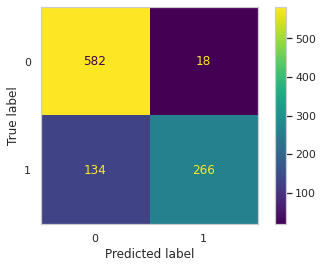

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test)

# Accuracy
score = accuracy_score(y_test, y_pred) * 100
print ("Accuracy: ", score)

# F1 score
f1_score = round(f1_score(y_test, y_pred, pos_label=1), 1) * 100
print("F1 Score: ", f1_score)
 
# Confusion Matrix
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()

plt.grid(False)
plt.show()


Prepare data into PyTorch tensors. You don't need to worry about this at this moment.

Let's say your train/dev/test features are named `X_train`, `X_dev`, `X_test`:

## PyTorch implementation

Convert the feature vectors to numpy arrays. Say you have arrays `X_train`,`X_dev`,`X_test`. Change the variable names to yours if needed.

In [ ]:
X_train_array = X_train.toarray().astype('float32')
X_dev_array = X_dev.toarray().astype('float32')
X_test_array = X_test.toarray().astype('float32')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

Simply call the scikit-learn libraries is not exciting. In this step, we implement our own Logistic Regression model with Pytorch.

In [ ]:
import torch

class LRClassifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LRClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

Specify the input dimensions and output dimensions of our LR model:

In [ ]:
input_dim = len(vocab)     # Number of distinct words in the vocabulary observed over all tweets
output_dim = len(labels)   # Number of classification classes = 2 = binary classifier

Create instances of this model with specified input/output dimensions. No need to care about optimizer and loss function at this moment.

In [ ]:
model = LRClassifier(input_dim, output_dim)

In [ ]:
model.to("cuda") ### make the model use GPU to boost the training

LRClassifier(
  (linear): Linear(in_features=32817, out_features=2, bias=True)
)

## Training

Our first training loop!

Input text_tensor is in shape [input_dim]


Label is in shape [1, output_dim]

`convert_to_one_hot` function can change one label digit to the required shape. For example, label `0` to '[1, 0]', `1` to '[0, 1]'.

In [ ]:
epochs = 1000
learning_rate = 0.5

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) ### no need to care about this optimizer at this moment
loss_fn = nn.BCELoss() 

In [ ]:
def convert_to_one_hot(label_tensor):
    return F.one_hot(label_tensor, num_classes=2).float()

In [ ]:
convert_to_one_hot(torch.tensor(1)) ### example 1

tensor([0., 1.])

In [ ]:
convert_to_one_hot(torch.tensor([1,0,1])) ### example 2

tensor([[0., 1.],
        [1., 0.],
        [0., 1.]])

In [ ]:
def train(model, optimizer, tweets, labels):
    model.train() # no need to change
    epoch_loss = []

    for text, label in zip(tweets, labels):

        # convert input and labels to PyTorch tensor if didn't do, make them on gpu
        text_tensor = torch.tensor(text).to("cuda")
        label = convert_to_one_hot(torch.tensor(label)).to("cuda")

        # the model should take vectors that representing a piice of text
        # predicted probability distributions
        output = model(text_tensor)

        # the loss is between the predictions and the true label
        # calculate loss, no need to change
        loss = loss_fn(output, label)
        epoch_loss.append(loss.item())
    
        # Backward pass, no need to change
        optimizer.zero_grad()
        loss.backward()

        # Step with optimizer, no need to change
        optimizer.step()

    # calculate the avg of accumulated losses
    return sum(epoch_loss)/len(epoch_loss)

You may notice this training takes quite some time. 
Run it but no need to wait till it ends, you can stop it when you see the estimated time.

In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(epochs)):

    epoch_loss = train(model, optimizer, X_train_array, y_train)

    # Report metrics every 190 epochs
    if ((epoch+1) % 100) == 0:
        print(epoch_loss)

 10%|█         | 100/1000 [04:50<43:18,  2.89s/it]

0.0016483258458429983


 10%|█         | 101/1000 [04:54<43:43,  2.92s/it]


KeyboardInterrupt: ignored

In [ ]:
### evaluation script
### no need to run if things above takes so long

@torch.no_grad() ### don't change
def evaluate(model, tweets): ### input: feature vectors
    model.eval() ### don't change
    preds = []
    for text in tweets:
        text_tensor = torch.unsqueeze(torch.tensor(text), 0).to("cuda")
        output = model(text_tensor)
        pred = torch.argmax(output, dim=1)
        preds.append(pred.item())

    return preds

In [ ]:
test_pred = evaluate(model, X_test_array) ### no need to run if things above takes so long

Accuracy:  84.3
F1 Score:  80.0


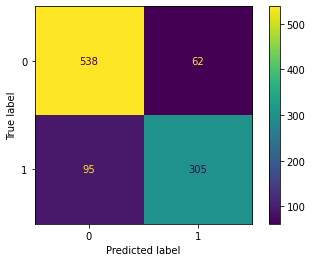

In [ ]:
### no need to run if things above takes so long
### code to show your evaluation result
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

# Accuracy
score = accuracy_score(y_test, test_pred) * 100
print ("Accuracy: ", score)

# F1 score
f1_score = round(f1_score(y_test, test_pred, pos_label=1), 1) * 100
print("F1 Score: ", f1_score)
 
# Confusion Matrix
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred)

cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()

plt.grid(False)
plt.show()

You may notice this training takes quite some time. 

No need to wait till it ends, let's modify it to make it run in `batches`, which means the model will take `N * feature_dimenson` features and `N` labels at one pass. This change should make the training way faster.

## Train in batch

In [ ]:
### create a new model using the same setting
model_batch = LRClassifier(input_dim, output_dim)
optimizer_batch = torch.optim.SGD(model_batch.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
model_batch.to("cuda") ### gpu accelearting

LRClassifier(
  (linear): Linear(in_features=32817, out_features=2, bias=True)
)

 Let's make it run in batches:

In [ ]:
'''
Source: https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00
'''
from torch.utils.data import Dataset, DataLoader

class CustomTextDataset(Dataset):

    def __init__(self, txt, labels):
        self.text = txt
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample = {'Text': text, 'Label': label}
        return sample

In [ ]:
### modify the train loop above and make it run in batches
def train_batch(model, optimizer, tweets, labels, batch_size = 100): 
    model.train() # no need to change
    epoch_loss = []
    total_acc, total_count = 0, 0

    # convert the tweets and labels into a custom dataset to do matrix multiplications
    TD = CustomTextDataset(tweets, labels)
    train_loader = torch.utils.data.DataLoader(TD, batch_size=batch_size)

    for idx, sample in enumerate(train_loader):

      text, label = sample['Text'], sample['Label']

      # convert input and labels to PyTorch tensor if didn't do, make them on gpu
      text_tensor = text.to("cuda")
      label = convert_to_one_hot(label).to("cuda")

      # the model should take vectors that representing a piice of text
      # predicted probability distributions
      output = model(text_tensor)

      # the loss is between the predictions and the true label
      # calculate loss, no need to change
      loss = loss_fn(output, label)
      epoch_loss.append(loss.item()/batch_size)
  
      # Backward pass, no need to change
      optimizer.zero_grad()
      loss.backward()

      # Step with optimizer, no need to change
      optimizer.step()

    # calculate the avg of accumulated losses
    return (sum(epoch_loss)/len(epoch_loss))

In [ ]:
from tqdm import tqdm

y_train = y_train.tolist()

for epoch in tqdm(range(epochs)):
  epoch_loss = train_batch(model_batch, optimizer_batch, X_train_array, y_train, batch_size = 100)

  # Report metrics every 100 epochs
  if ((epoch+1) % 100) == 0:
    print('\t | Epoch_loss: ', epoch_loss)

 10%|█         | 100/1000 [00:27<03:35,  4.17it/s]

	 | Epoch_loss:  0.001568987988999912


 20%|██        | 200/1000 [00:51<03:10,  4.20it/s]

	 | Epoch_loss:  0.0009059636848313469


 30%|███       | 300/1000 [01:15<02:46,  4.21it/s]

	 | Epoch_loss:  0.000628749522779669


 40%|████      | 400/1000 [01:39<02:22,  4.20it/s]

	 | Epoch_loss:  0.00047831407934427266


 50%|█████     | 500/1000 [02:03<01:58,  4.22it/s]

	 | Epoch_loss:  0.0003846501213099274


 60%|██████    | 600/1000 [02:27<01:35,  4.17it/s]

	 | Epoch_loss:  0.0003210416963057858


 70%|███████   | 700/1000 [02:51<01:11,  4.21it/s]

	 | Epoch_loss:  0.0002751614541879723


 80%|████████  | 800/1000 [03:15<00:48,  4.13it/s]

	 | Epoch_loss:  0.00024057085439562807


 90%|█████████ | 900/1000 [03:39<00:24,  4.11it/s]

	 | Epoch_loss:  0.00021359415033033913


100%|██████████| 1000/1000 [04:03<00:00,  4.10it/s]

	 | Epoch_loss:  0.00019198614811258657


In [ ]:
test_pred = evaluate(model_batch, X_test_array) ### eval on test set

Accuracy:  84.7
F1 Score:  80.0


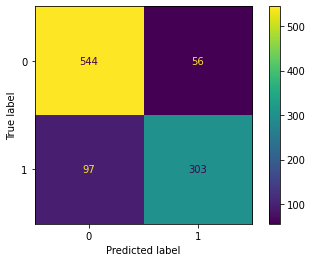

In [ ]:
### code to show your evaluation result

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

# Accuracy
score = accuracy_score(y_test, test_pred) * 100
print ("Accuracy: ", score)

# F1 score
f1_score = round(f1_score(y_test, test_pred, pos_label=1), 1) * 100
print("F1 Score: ", f1_score)
 
# Confusion Matrix
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred)

cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()

plt.grid(False)
plt.show()

## Early stopping
The batch-ed training works much faster even if we train it for 1000 epochs!

But is it the best practice to train 1000 epochs under any circumstances? No, we should make the training stop at an optimal point that the model is not overfitted and can give best performance on unseen data. Also, we will save time during the training.

We will then introduce `early stop` to our training loop. By montoring the loss on the dev data, we will know when is the best time to stop training.

In [ ]:
model_batch = LRClassifier(input_dim, output_dim)
optimizer_batch = torch.optim.SGD(model_batch.parameters(), lr=0.5, momentum=0.9)

In [ ]:
model_batch.to("cuda")

LRClassifier(
  (linear): Linear(in_features=32817, out_features=2, bias=True)
)

Hint: this function below helps to get evaluation loss

In [ ]:
@torch.no_grad()
def evaluate_loss(model, tweets, labels):
    model.eval()
    epoch_loss = []
    for text, label in zip(tweets, labels):
      
        text_tensor = torch.tensor(text).to("cuda")
        label = convert_to_one_hot(torch.tensor(label)).to("cuda")

        output = model(text_tensor)
        loss = loss_fn(output, label)
        
        epoch_loss.append(loss.item())
    
    return sum(epoch_loss)/len(epoch_loss)

In [ ]:
@torch.no_grad()
def evaluate(model, tweets):
    model.eval()
    preds = []
    for text in tweets:
        text_tensor = torch.unsqueeze(torch.tensor(text), 0).to("cuda")
        output = model(text_tensor)
        pred = torch.argmax(output, dim=1)
        preds.append(pred.item())

    return preds

In [ ]:
### your code to implement early stop
early_stop_epsilon = 0.00005
patience = 20
epochs_since_improvement = 0
prev_validation_loss = None

for epoch in tqdm(range(epochs)):

    epoch_loss = train_batch(model_batch, optimizer_batch, X_train_array, y_train, batch_size = 100)

    # Check validation error
    validation_loss = evaluate_loss(model_batch, X_dev_array, y_dev)

    # Reset the improvement patience if the validation loss improves enough since last epoch
    if prev_validation_loss:
      if prev_validation_loss - validation_loss >= early_stop_epsilon:
        epochs_since_improvement = 0

    # Early stop if too many epochs have passed without improvement
    if epochs_since_improvement >= patience:
      break
    
    # Update the record of validation loss per epoch
    prev_validation_loss = validation_loss
    epochs_since_improvement += 1      

    # Report metrics every 50 batch
    if ((epoch+1) % 50) == 0:
        print(epoch_loss)


  5%|▌         | 50/1000 [00:20<06:37,  2.39it/s]

0.0024164894052914215


 10%|█         | 100/1000 [00:42<06:37,  2.27it/s]

0.0015690096616744996


 15%|█▌        | 150/1000 [01:03<05:52,  2.41it/s]

0.001152662049446787


 19%|█▉        | 193/1000 [01:23<05:48,  2.31it/s]


In [ ]:
test_pred = evaluate(model_batch, X_test_array)

Accuracy:  85.0
F1 Score:  80.0


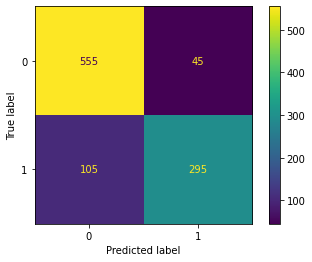

In [ ]:
### your evaluation code
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

# Accuracy
score = accuracy_score(y_test, test_pred) * 100
print ("Accuracy: ", score)

# F1 score
f1_score = round(f1_score(y_test, test_pred, pos_label=1), 1) * 100
print("F1 Score: ", f1_score)
 
# Confusion Matrix
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred)

cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()

plt.grid(False)
plt.show()

Well done! You should be able to see the performance is equally good or even better after applying `early stopping`.


Please think about your accomplishment and do some error analysis, then finish the report.


## Experiments

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       600
           1       0.89      0.62      0.73       400

    accuracy                           0.82      1000
   macro avg       0.84      0.78      0.80      1000
weighted avg       0.83      0.82      0.81      1000



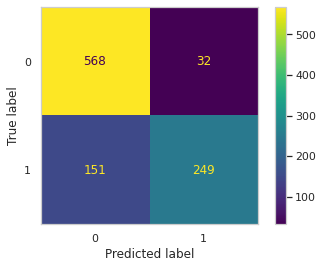

In [ ]:
# Logistic Regression
import sklearn.linear_model as linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
lr = linear_model.LogisticRegression(C=1)
lr.fit(X_train, y_train)
y_pred1 = lr.predict(X_test)
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred1)
print(classification_report(y_test, y_pred1))
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()
plt.grid(False)
plt.show()

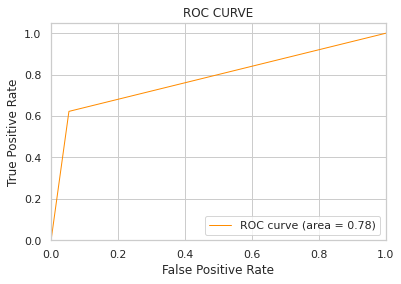

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       600
           1       0.85      0.65      0.73       400

    accuracy                           0.81      1000
   macro avg       0.82      0.79      0.80      1000
weighted avg       0.82      0.81      0.81      1000



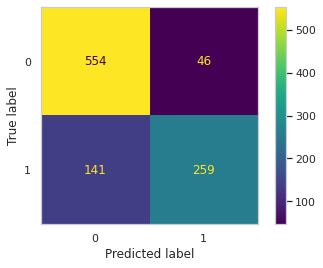

In [ ]:
#Bernoulli naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred2 = BNBmodel.predict(X_test)
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred2)
print(classification_report(y_test, y_pred2))
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()
plt.grid(False)
plt.show()

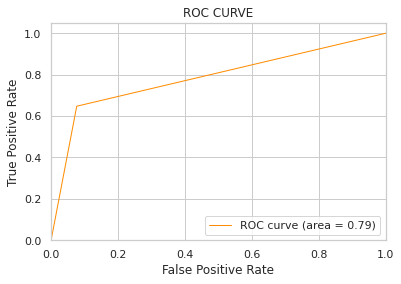

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       600
           1       0.82      0.72      0.77       400

    accuracy                           0.83      1000
   macro avg       0.83      0.81      0.81      1000
weighted avg       0.83      0.83      0.82      1000



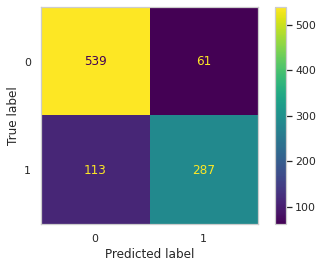

In [ ]:
#linear SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_pred3 = SVCmodel.predict(X_test)
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred3)
print(classification_report(y_test, y_pred3))
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_plot.plot()
plt.grid(False)
plt.show()


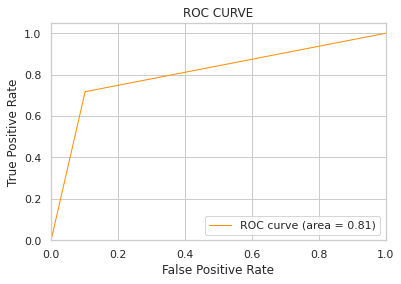

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()